In [1]:
# T cell specific clustering and factor analysis
# 8/31/2021
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import pandas as pd
import re
import numpy as np
import glob
from scipy import sparse
from scipy import stats
from copy import deepcopy
import csv
import itertools
import warnings
import sys
import scanpy as sc
from collections import Counter
from collections import namedtuple
#import schpf
import phenograph
#import plotly.figure_factory as ff
## functions for dendrogram stuff
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance
#from pygg import *
import mygene


In [8]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.settings.figdir = figure_dir

/Users/roses3/miniconda3/envs/workshop_2023/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


# load data

In [3]:
# load in raw and SCRAN normalized data

adata_file = '/Users/roses3/Dropbox/lung_tumor/sr/data/htan/split/tnk/luad_only/ad_tnk_20210830.h5ad'
adata = sc.read_h5ad(adata_file)
adata.raw = adata

adata_scran_file = '/Users/roses3/Dropbox/lung_tumor/sr/data/htan/split/tnk/luad_only/ad_tnk_scranLogNorm_20210830.h5ad'
adata_scran = sc.read_h5ad(adata_scran_file)


/Users/roses3/miniconda3/envs/workshop_2023/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
## assign new index names to the adata_scran.obs object if necessary
adata_scran.obs.index = adata.obs.index

In [5]:
# now set the raw object
adata_scran.raw = adata_scran

In [6]:
# recalculate the qc metrix
sc.pp.calculate_qc_metrics(adata, inplace = True)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
adata_scran = adata_scran[adata.obs.index.values]
adata_scran = adata_scran[:,adata.var.index.values]
adata_scran

View of AnnData object with n_obs × n_vars = 38241 × 25944
    obs: 'sample_name', 'histology', 'Procedure_Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'Phenograph_cluster', 'sizeFactor'
    uns: 'Phenograph_cluster_colors', 'dendrogram_Phenograph_cluster', 'neighbors', 'pca', 'sample_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

# feature selection

In [9]:
# need to filter out genes that aren't expressed
# doing the same strategy as scHPF, .1% of cells
num_min_cells = adata.shape[0] * .001
sc.pp.filter_genes(adata, min_cells = num_min_cells)
# keep the genes that aren't filtered out by this
adata_scran = adata_scran[:,adata.var.index.values]

filtered out 11796 genes that are detected in less than 38.241 cells


In [11]:
adata_scran

View of AnnData object with n_obs × n_vars = 38241 × 14148
    obs: 'sample_name', 'histology', 'Procedure_Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'Phenograph_cluster', 'sizeFactor'
    uns: 'Phenograph_cluster_colors', 'dendrogram_Phenograph_cluster', 'neighbors', 'pca', 'sample_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [10]:
# read in stress response geneset and TCR genes
stress_genes = pd.read_csv("/Users/roses3/Dropbox/reference_genomes/Homo_sapiens/annotations/stress_response_set_OFlanagan_etal.csv")
tcr_genes = pd.read_csv("/Users/roses3/Dropbox/reference_genomes/Homo_sapiens/annotations/tcr_genes.txt", delimiter = "\t")
# load low transcript support genes defined from ensembl gtf
low_tsl_genes = pd.read_csv("/Users/roses3/Dropbox/reference_genomes/Homo_sapiens/ensembl/ensembl_85/tsl45_genes.csv")
# filter out genes I want to keep from the low tsl genes
low_tsl_genes = low_tsl_genes[low_tsl_genes['gene_name'] != 'IFNA1']

In [11]:
mg = mygene.MyGeneInfo()
stress_genes_symbol = mg.querymany(stress_genes['ensembl_gene_id'].values, scopes='ensembl.gene')


querying 1-512...done.
Finished.
5 input query terms found no hit:
	['ENSG00000269028', 'ENSG00000255823', 'ENSG00000256045', 'ENSG00000112096', 'ENSG00000256618']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [12]:
stress_symbols = [sub['symbol'] for sub in stress_genes_symbol if 'symbol' in sub]

In [13]:
adata.var_names.isin(stress_symbols).sum()

442

In [14]:
adata.var_names.isin(tcr_genes['Approved symbol'].values).sum()

76

In [15]:
# get hvg in case I need
# will get 2,000
bad_genes = adata.var_names.str.contains(
    "^MT-|^MTMR|^MTND|NEAT1|TMSB4X|TMSB10|^RPS|^RPL|^MRP|^FAU$|UBA52|MALAT|^TRAV|TRBD1|^HLA\-|HBA[12]|^IG[HKL]|RP[1-9]+\-|^MTRNR") \
| adata.var_names.isin(stress_symbols) \
| adata.var_names.isin(tcr_genes['Approved symbol'].values) \
| adata.var_names.isin(low_tsl_genes)
bad_genes_symbols = adata.var_names[bad_genes]


In [18]:
bad_genes.sum()

1307

In [16]:
hvg_2k = sc.pp.highly_variable_genes(adata[:,~adata.var_names.isin(bad_genes_symbols)], flavor = 'seurat_v3', n_top_genes = 2000, inplace = False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


In [17]:
hvg_2k_genes = hvg_2k.index.values[hvg_2k['highly_variable'].values == True]

# Dim reduction and clustering

In [18]:
# Z-score the data
adata_scran_Z = adata_scran.copy()
adata_scran_Z.X = pd.DataFrame(adata_scran.X.todense()).apply(stats.zscore)

In [19]:
# set highly variable if necessary
adata_scran_Z.var['highly_variable'] = adata_scran_Z.var.index.isin(hvg_2k_genes)


In [20]:
sc.tl.pca(adata_scran_Z, use_highly_variable=True,
          svd_solver = 'arpack', n_comps = 100)

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:07)


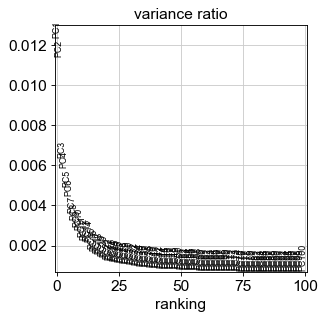

In [49]:
sc.pl.pca_variance_ratio(adata_scran_Z, log=False, n_pcs = 100)

In [21]:
sc.pp.neighbors(adata_scran_Z, n_neighbors=40, n_pcs=50)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)


In [54]:
sc.tl.umap(adata_scran_Z,  min_dist=0.3)#, neighbors_key='neighbors')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


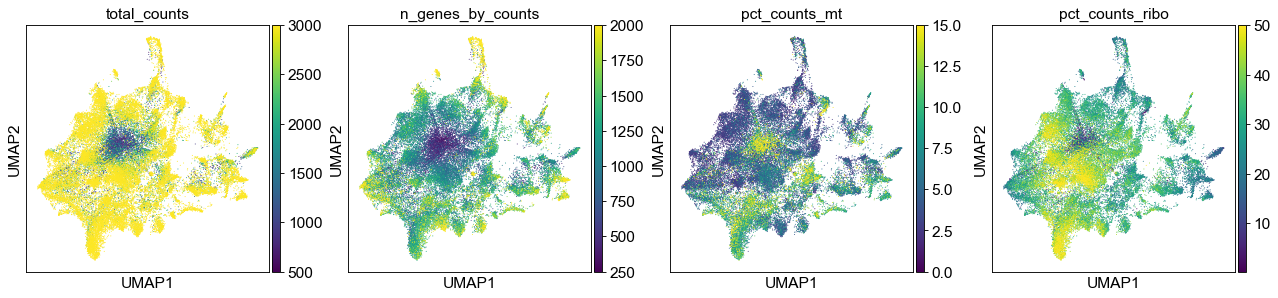

In [55]:
sc.pl.umap(adata_scran_Z, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
          vmax = [3000, 2000, 15, 50])

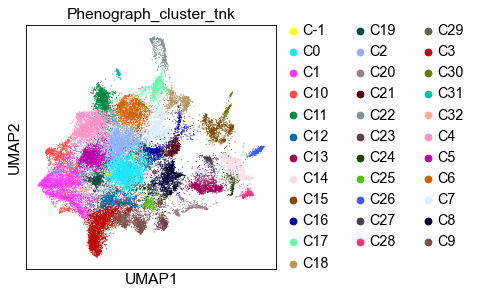

In [81]:
sc.pl.umap(adata_scran_Z, color = 'Phenograph_cluster_tnk')

## examining low quality cells 
I am noticing that there are what look to be low quality cells in the center of the UMAP, flagged by:
- high mito %
- low ribo %
- low library size
- low feature size

These will be removed as poor quality cells for subsequent analysis

In [23]:
low_quality_idx = (adata_scran_Z.obs[['n_genes_by_counts']] < 400).values & (adata_scran_Z.obs[['total_counts']] < 1000).values

In [24]:
low_quality_idx.sum()

1458

In [25]:
adata_scran_Z.obs['low_quality'] = low_quality_idx.astype('str')

# redo clustering removing low quality cells

* The clustering and dimensionality reduction will be redone after filtering out the low quality cells identified on the UMAP

In [28]:
adata_scran_Z_f = adata_scran_Z[adata_scran_Z.obs['low_quality'] == 'False',:].copy()

In [29]:
# recalculate HVG without low quality cells
hvg_2k = sc.pp.highly_variable_genes(adata[adata.obs.index.isin(adata_scran_Z_f.obs.index),~adata.var_names.isin(bad_genes_symbols)], flavor = 'seurat_v3', n_top_genes = 2000, inplace = False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


In [30]:
hvg_2k_genes = hvg_2k.index.values[hvg_2k['highly_variable'].values == True]

In [31]:
# set highly variable if necessary
adata_scran_Z_f.var['highly_variable'] = adata_scran_Z_f.var.index.isin(hvg_2k_genes)

In [32]:
sc.tl.pca(adata_scran_Z_f, use_highly_variable=True,
          svd_solver = 'arpack', n_comps = 100)

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:07)


In [33]:
sc.pp.neighbors(adata_scran_Z_f, n_neighbors=40, n_pcs=50)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [40]:
sc.tl.umap(adata_scran_Z_f,  min_dist=0.3, neighbors_key='neighbors')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


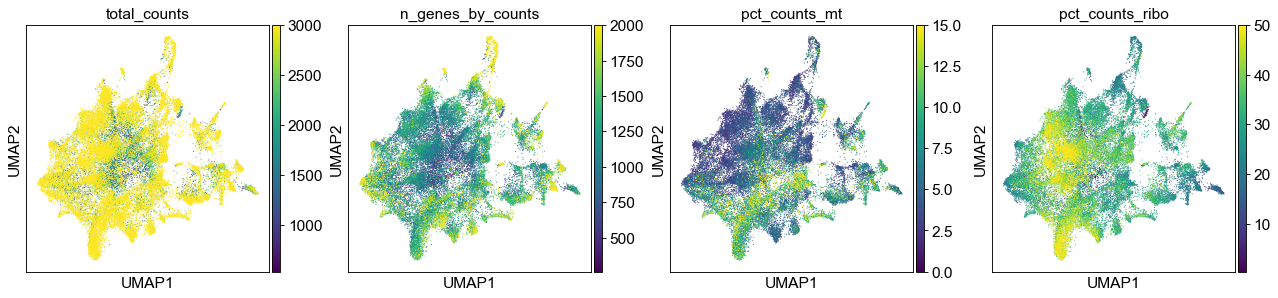

In [41]:
sc.pl.umap(adata_scran_Z_f, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
          vmax = [3000, 2000, 15, 50])

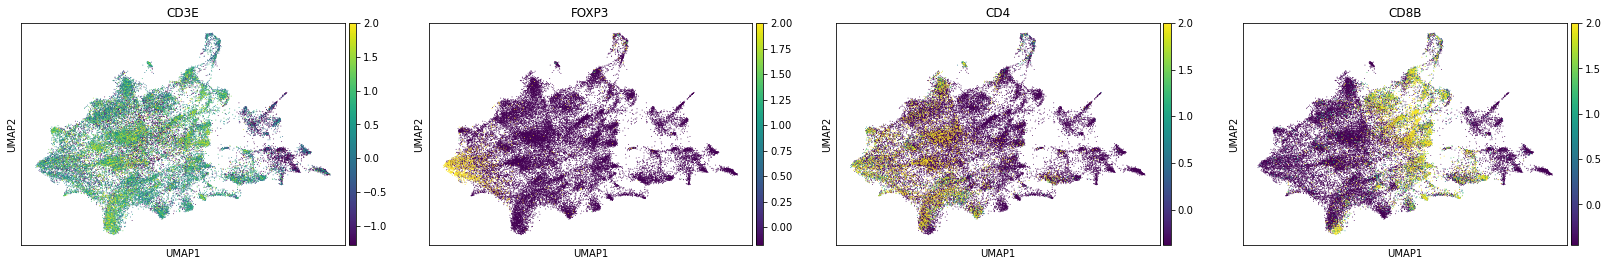

In [90]:
sc.pl.umap(adata_scran_Z_f, color = ['CD3E', 'FOXP3', 'CD4', 'CD8B'], vmax = 2, use_raw = False)

In [34]:
# do clustering
communities, graph, Q = phenograph.cluster(adata_scran_Z_f.obsm['X_pca'][:,0:50],
                                           k=40,clustering_algo='leiden',
                                           seed=0,min_cluster_size=50)
print(np.unique(communities,return_counts=True))
adata_scran_Z_f.obs['Phenograph_cluster_tnk'] = ['C' + str(x) for x in communities]
adata_scran_Z_f.obs['Phenograph_cluster_tnk'] = adata_scran_Z_f.obs['Phenograph_cluster_tnk'].astype("category")


Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.40310192108154297 seconds
Jaccard graph constructed in 2.4590249061584473 seconds
Running Leiden optimization
Leiden completed in 2.8920369148254395 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.406182765960693 seconds
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]), array([3290, 3133, 2837, 2662, 2125, 1788, 1763, 1679, 1317, 1250, 1179,
       1154, 1031, 1017,  984,  960,  895,  884,  816,  805,  788,  611,
        600,  534,  431,  389,  381,  352,  282,  260,  234,  186,  112,
         54]))


## plot lineage t-SNE

In [35]:
sc.tl.tsne(adata_scran_Z_f, n_pcs=50)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:08)


In [36]:
# get better plot quality for this
sc.settings.set_figure_params(dpi=300, facecolor='white')

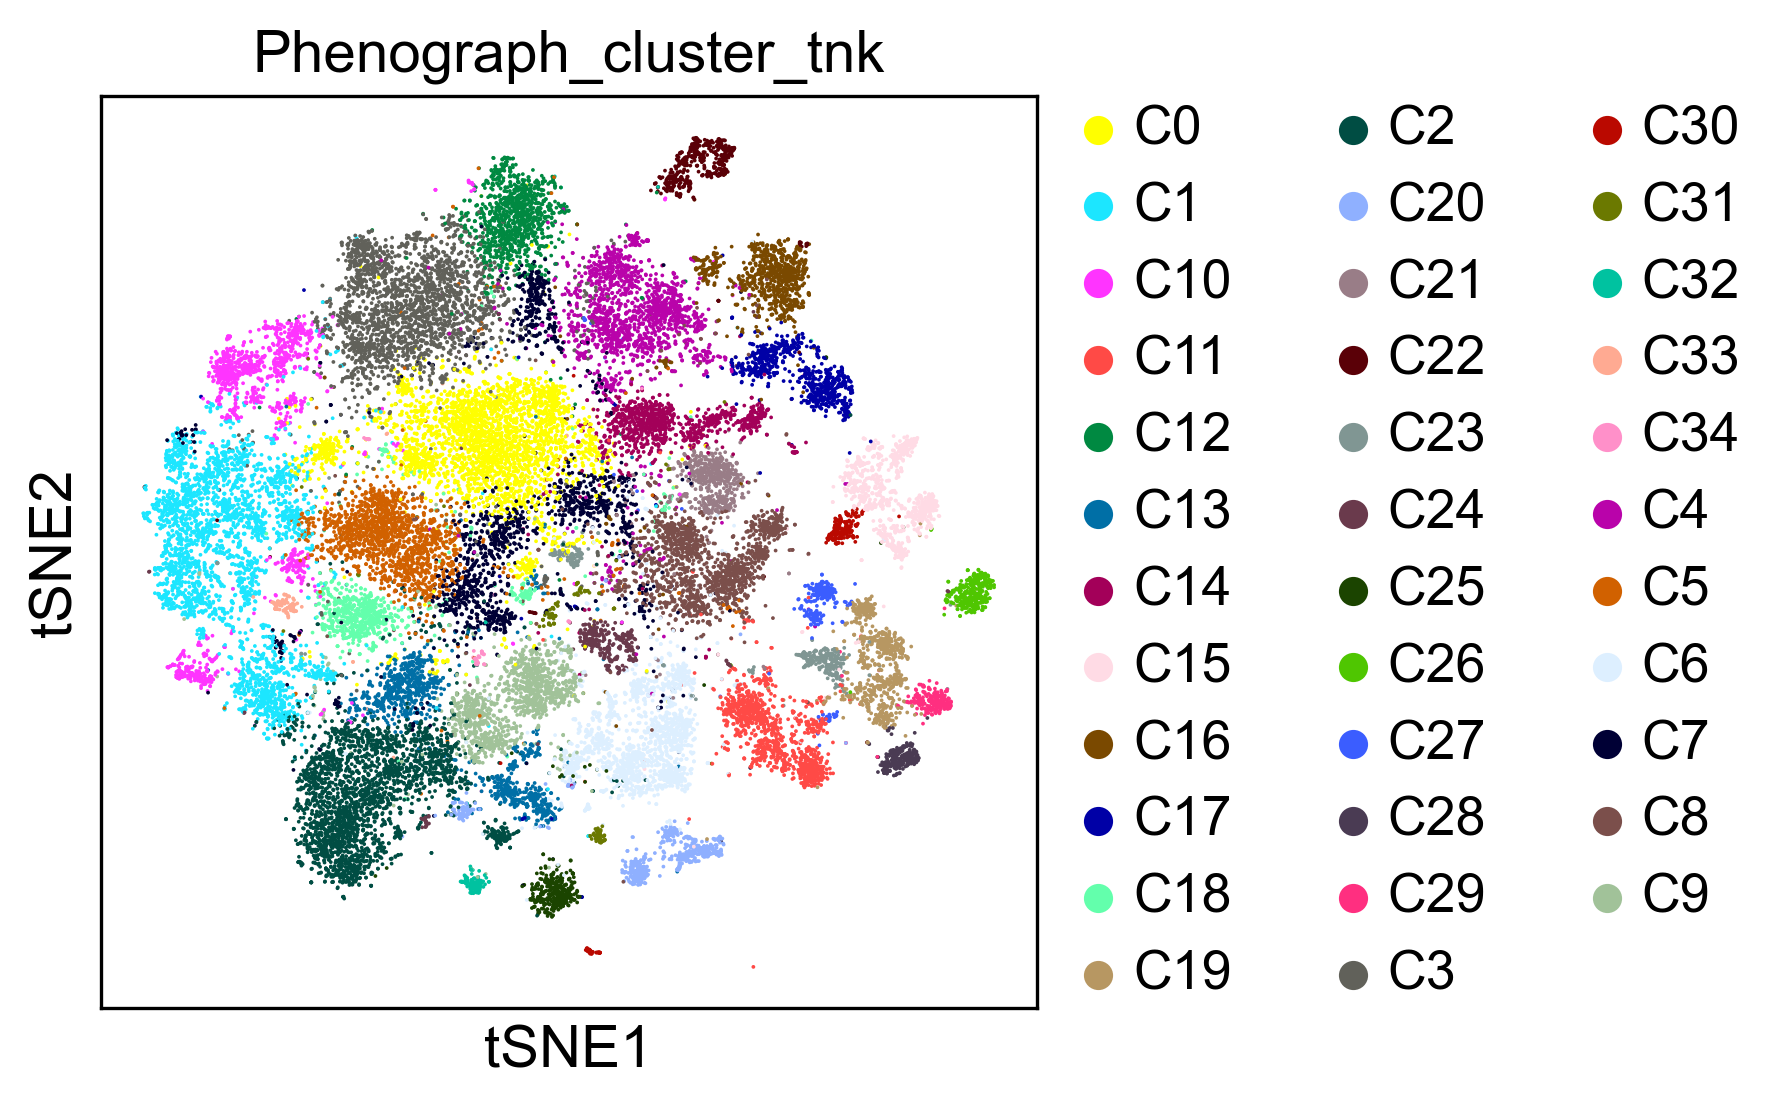

In [46]:
sc.pl.tsne(adata_scran_Z_f, color = 'Phenograph_cluster_tnk', save = "_tnk_Phenograph_rmBadCells.pdf")

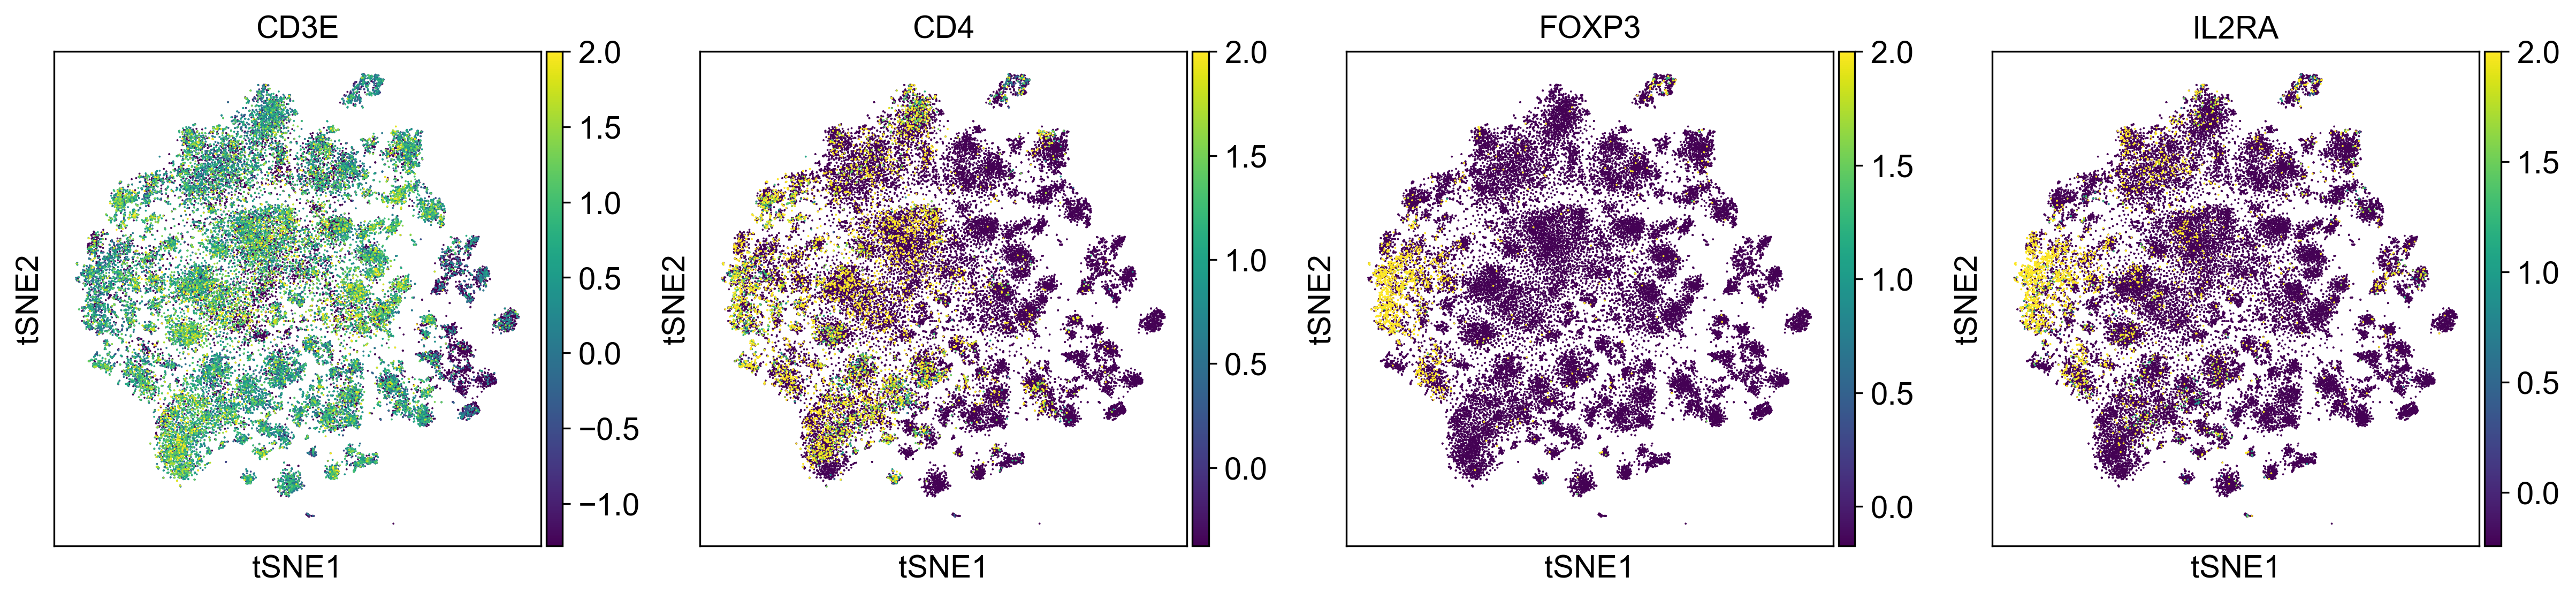

In [8]:
sc.pl.tsne(adata_scran_Z_f, color = ['CD3E', 'CD4', 'FOXP3', 'IL2RA'], vmax = 2, use_raw = False)#, save = '_tnk_tregMarkers_rmBadCells.pdf')

/Users/roses3/miniconda3/envs/workshop_2023/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


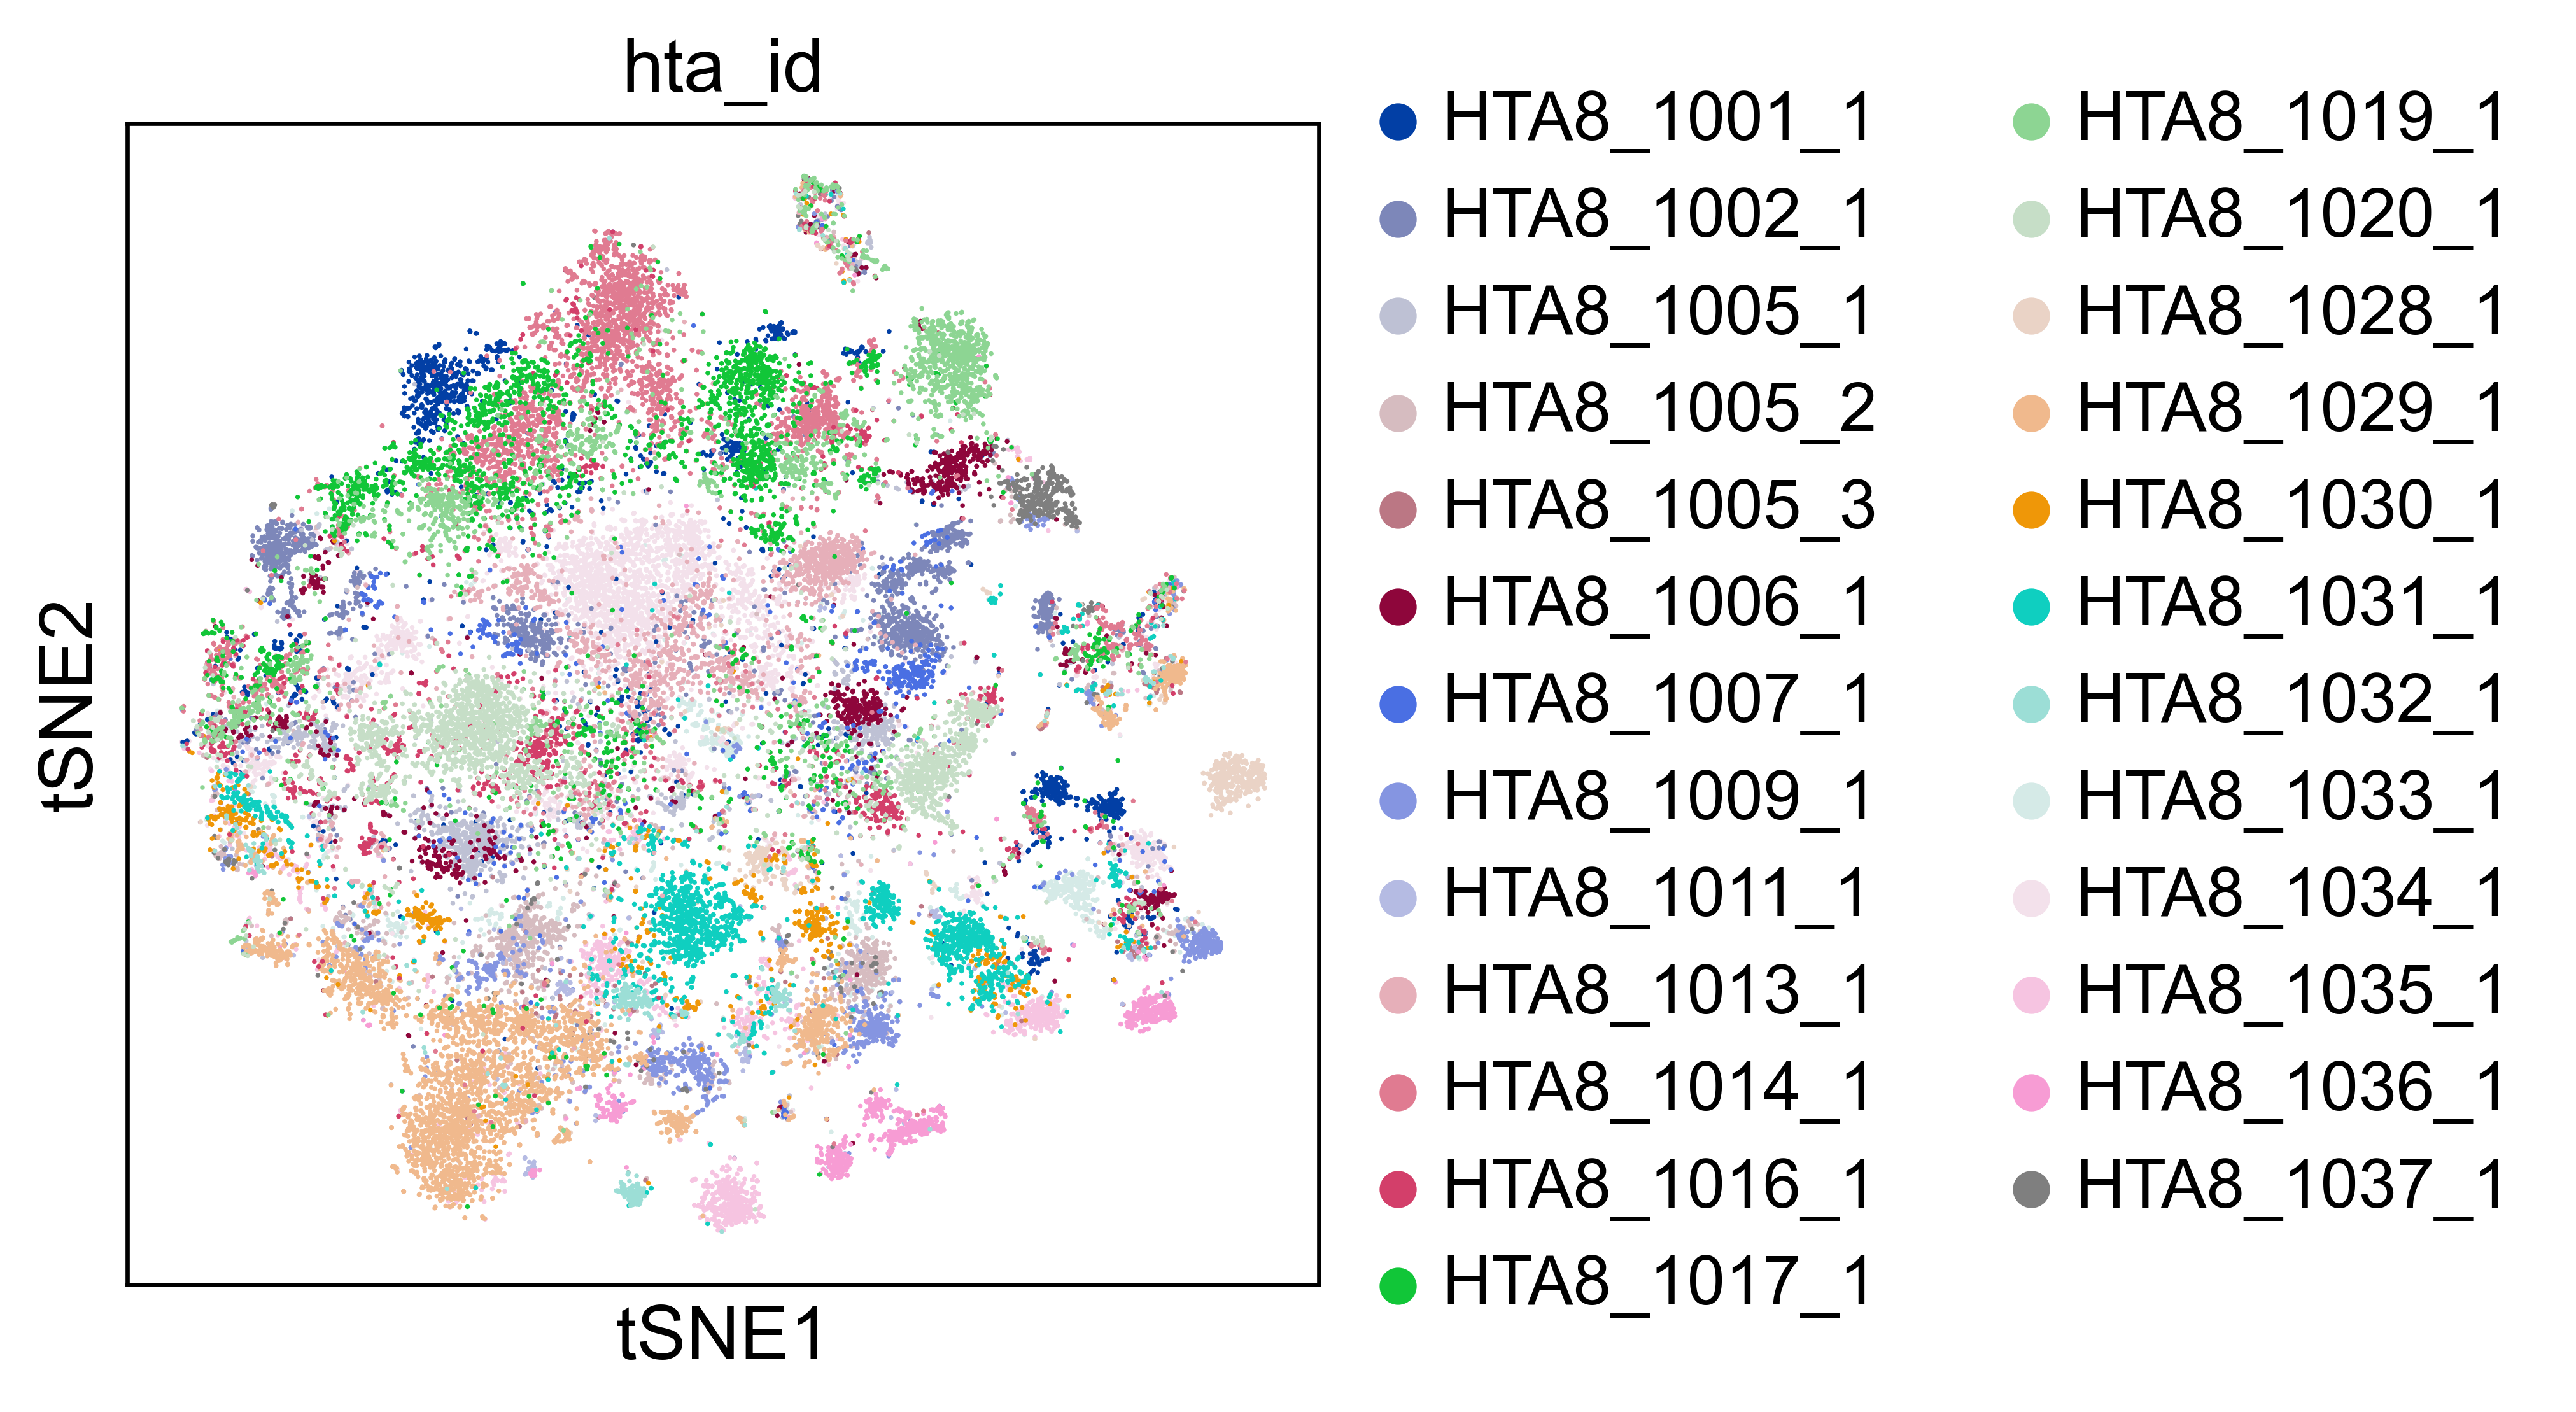

In [40]:
# plot the t-sne by sample
sc.pl.tsne(adata_scran_Z_f, color = 'hta_id', save = '_tnk_htaID_rmBadCells.pdf')